## Data 3550 Final Project
### Ayman Boules, Katherine Simon, Nicholas Sartino, Sammi Hamdan

# 1. Import the required packages

In [2]:
# Installs (comment out if you don't need)

# !pip-install missingno
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from numpy import arange

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

import statsmodels.api as sm

pd.set_option('display.max_columns',200) #allows for up to 200 columns to be displayed when viewing a dataframe
pd.set_option('display.max_rows',100)
# The following was commented out as it is deprecated and no longer works with current version.
#plt.style.use('seaborn') # a style that can be used for plots - see style reference above

# trick to widen the screen
from IPython.core.display import display, HTML

#Widens the code landscape 
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 1

## Load in the Dataset

In [6]:
df = pd.read_csv('College_Admission_data.csv')

## Data Exploratory Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Columns: 108 entries, Name to Endowment assets (year end) per FTE enrollment (FASB)
dtypes: float64(97), object(11)
memory usage: 1.3+ MB


In [8]:
df.describe()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [9]:
df.head()

,Name,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,State abbreviation,FIPS state code,Geographic region,Sector of institution,Level of institution,Control of institution,Historically Black College or University,Tribal college,Degree of urbanization (Urban-centric locale),Carnegie Classification 2010: Basic,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of

C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\842357978.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


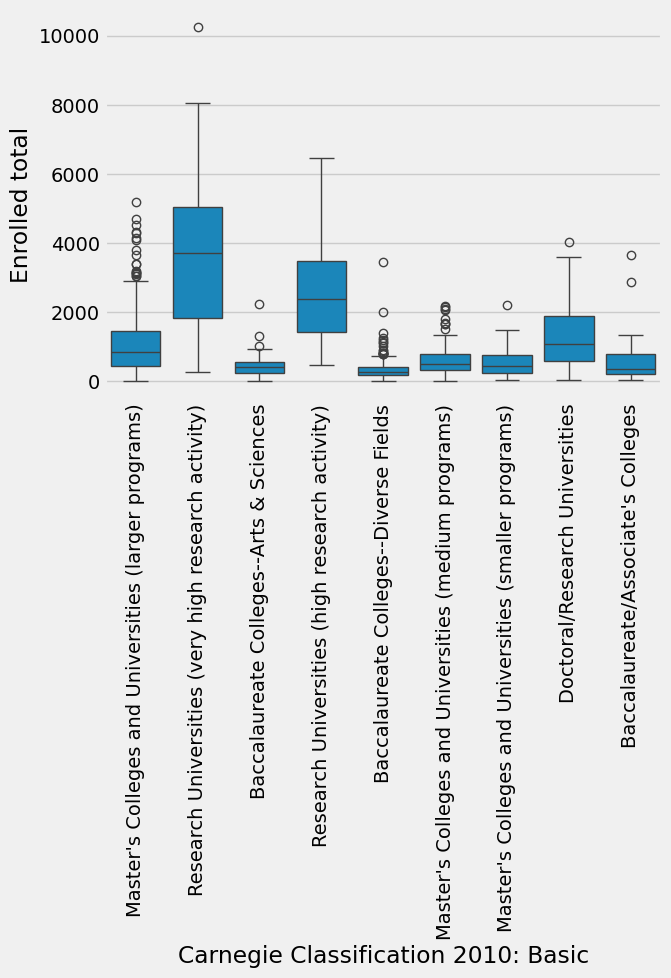

In [40]:
ax = sns.boxplot(x='Carnegie Classification 2010: Basic',y='Enrolled total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\1028088251.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


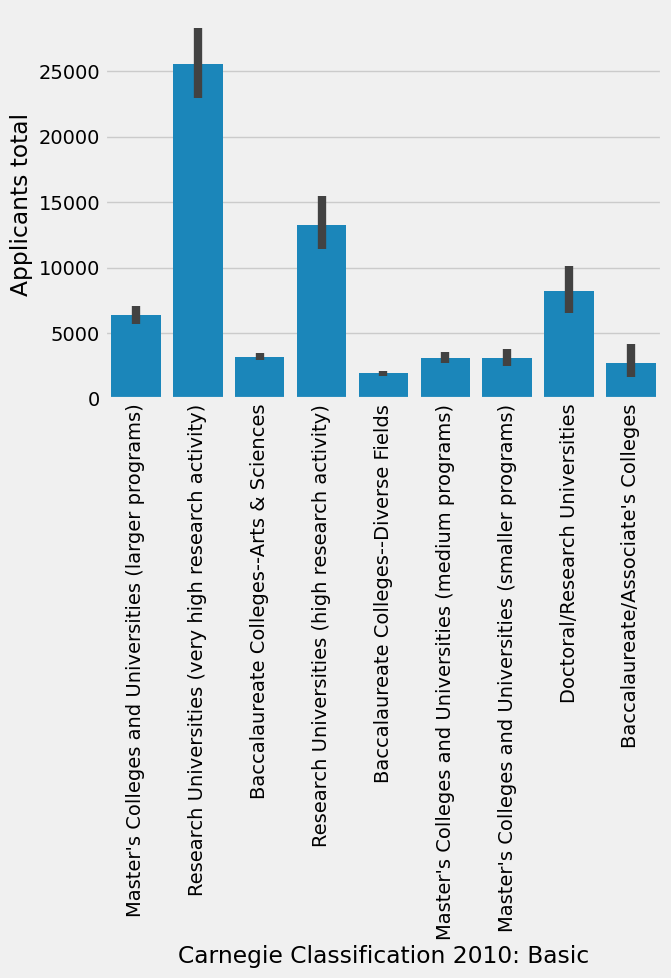

In [41]:
ax = sns.barplot(x='Carnegie Classification 2010: Basic', y='Applicants total', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

## Data Preprocessing

In [55]:
# Assuming 'df' is your DataFrame and 'cat_column' is the column with categorical values
distinct_values = df['Carnegie Classification 2010: Basic'].unique()

print(distinct_values)

["Master's Colleges and Universities (larger programs)"
 'Research Universities (very high research activity)'
 'Baccalaureate Colleges--Arts & Sciences'
 'Research Universities (high research activity)'
 'Baccalaureate Colleges--Diverse Fields'
 "Master's Colleges and Universities (medium programs)"
 "Master's Colleges and Universities (smaller programs)"
 'Doctoral/Research Universities' "Baccalaureate/Associate's Colleges"]


In [57]:
mapping = {
    "Baccalaureate/Associate's Colleges": 1,
    'Baccalaureate Colleges--Diverse Fields': 2,
    'Baccalaureate Colleges--Arts & Sciences': 3,
    "Master's Colleges and Universities (smaller programs)": 4,
    "Master's Colleges and Universities (medium programs)": 5,
    "Master's Colleges and Universities (larger programs)": 6,
    'Research Universities (high research activity)': 7,
    'Research Universities (very high research activity)': 8,
    'Doctoral/Research Universities': 9
}
df['Carnegie Classification 2010: Basic'] = df['Carnegie Classification 2010: Basic'].replace(mapping)

In [28]:
# Splitting the target variable and features
X = df.drop('Carnegie Classification 2010: Basic', axis=1)
y = df['Carnegie Classification 2010: Basic']

In [29]:
# Convert the categorical target variable into a numerical variable.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert the encoded labels back to the original categories
# y = le.inverse_transform(y_encoded)

# Convert categorical features into numerical features.
df_dummies = pd.get_dummies(X, drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Columns: 1735 entries, Applicants total to Degree of urbanization (Urban-centric locale)_Town: Remote
dtypes: bool(1638), float64(97)
memory usage: 3.5 MB


In [26]:
df_dummies.head()

,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time","Estimated freshman undergraduate enrollment, total","Estimated freshman enrollment, full time","Estimated freshman enrollment, part time","Estimated graduate enrollment, total","Estimated graduate enrollment, full time","Estimated graduate enrollment, part time",Number of students receiving an Associate's degree,Percent admitted - total,Admissions yield - total,"Tuition and fees, 2010-11","Tuition and fees, 2011-12","Tuition and fees, 2012-13","Tuition and fees, 2013-14",Total price for in-state students living on campus 2013-14,Total price for out-of-state students living on campus 2013-14,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,Graduate enrollment,Full-time undergraduate enrollment,Part-time undergraduate enrollment,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women,Percent of undergraduate enrollment that are American Indian or Alaska Native,Percent of undergraduate enrollment that are Asian,Percent of undergraduate enrollment that are Black or African American,Percent of undergraduate enrollment that are Hispanic/Latino,Percent of undergraduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 

In [30]:
# Find columns with missing values and their counts
missing_counts = df_dummies.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Applicants total                                                                           157
Admissions total                                                                           157
Enrolled total                                                                             157
Percent of freshmen submitting SAT scores                                                  277
Percent of freshmen submitting ACT scores                                                  275
SAT Critical Reading 25th percentile score                                                 365
SAT Critical Reading 75th percentile score                                                 365
SAT Math 25th percentile score                                                             352
SAT Math 75th percentile score                                                             352
SAT Writing 25th percentile score                                                          820
SAT Writing 75th percentile score                 

### Data Imputation
* There are a lot of variables with missing values. Many of them are correlated as well. For example, all of the enrollment variables have exactly 2 missing values.
* The goal in this section will be to try to maintain the representation of the data, which means that no statistical value will be used to fill in an NA.

#### Rules that will be followed:
* columns having at least half of its values being missing values will be dropped.
* columns having a significant number of missing values (>=100) will have its values substituted with the median (assuming a normal distribution).
* columns columns having an insignificant number of missing values will be substituted with appropriate values that indicate that those values were not given.

In [31]:
# Removing columns with a very large amount of missing values

# Threshold
prop = 0.5

# Drop columns with more than 'prop' proportion of missing values
df_filtered = df_dummies.dropna(thresh=int(df_dummies.shape[0] * prop), axis=1)

In [32]:
# Handling columns having a significant number of missing values

# Threshold
min_missing_values = 100

# Go through each column in the DataFrame
for col in df_filtered.columns:
    # If the column has 100 or more missing values
    if df_filtered[col].isna().sum() >= min_missing_values:
        # Fill the missing values with the median of the column
        df_filtered[col].fillna(df_filtered[col].median(), inplace=True)

C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\3442731007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(df_filtered[col].median(), inplace=True)
C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\3442731007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col].fillna(df_filtered[col].median(), inplace=True)
C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\3442731007.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [33]:
# Handling columns having an insignificant number of missing values.

# Fill in the rest of the missing values with -1.
df_filtered.fillna(-1, inplace=True)

C:\Users\shamd\AppData\Local\Temp\ipykernel_126444\3803991671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.fillna(-1, inplace=True)


In [34]:
# Find columns with missing values and their counts
missing_counts = df_filtered.isnull().sum()

# Filter and print columns with missing values
columns_with_missing_values = missing_counts[missing_counts > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


### Train Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered,y_encoded,test_size=0.3,random_state=21)

### Summary of Section
* Categorical variables were converted into numerical variables.
* Missing values were handled according to the rules determined.
* The data was split into training and testing sets.

# Step 2

# Step 6

In [49]:
# Create A regression model to analyze the admission rate based on factors such as the number of applicants, tuition, average SAT and ACT scores, and other relevant metricds we find.

# Admission rate = total admissions / applicants total

X2 = df.drop('Percent admitted - total',axis=1)
y2 = df['Percent admitted - total']

In [51]:
df_dummies = pd.get_dummies(X2, drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Columns: 1742 entries, Applicants total to Carnegie Classification 2010: Basic_Research Universities (very high research activity)
dtypes: bool(1646), float64(96)
memory usage: 3.5 MB


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_dummies = df_dummies.applymap(int)
vif = pd.DataFrame()
vif["variables"] = df_dummies.columns
vif["VIF"] = [variance_inflation_factor(df_dummies.values, i) for i in range(df_dummies.shape[1])]
vif

ValueError: cannot convert float NaN to integer

## LASSO Model Regression

## Ridge Model Regression

## Random Forest Regression